# SI 618 Project - Machine Learning

## Project Title: **Unveiling Patterns in Amazon Book Reviews: Clustering Analysis with NLP Techniques**
### Team 13 (Uniquename): *ChengYu Ko (cyko)*, *Ying Wang (mmywang)*, *Junyi Deng (junyiden)*

In [1]:
import os
import datetime, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind
from statsmodels.formula.api import ols
import string
import contractions
import re
import spacy
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from IPython.display import Image
from sklearn.metrics import mean_squared_error, silhouette_score, silhouette_samples, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE

# Set the desired number of CPU cores
os.environ['LOKY_MAX_CPU_COUNT'] = '16'

## Data Loading and Manipulation (Adapted from Project 1)

In [2]:
# Load the raw datasets
reviews = pd.read_csv('Books_rating.csv')
books = pd.read_csv('books_data.csv')

In [3]:
# Select the variables of interest
selected_reviews = ['Id', 'Title', 'User_id', 'profileName', 'review/helpfulness', 'review/score', 'review/time', 'review/summary', 'review/text']
selected_books = ['Title', 'description', 'authors', 'publisher', 'publishedDate', 'categories']

reviews_df = reviews[selected_reviews]
books_df = books[selected_books]

In [4]:
# Create copies of the DataFrame
reviews_df = reviews_df.copy()
books_df = books_df.copy()

# Drop missing values in the "Title" column
reviews_df.dropna(subset=['Title'], inplace=True)
books_df.dropna(subset=['Title'], inplace=True)

# Drop duplicates in the "Title" column
reviews_df.drop_duplicates(subset=['Title'], inplace=True)
books_df.drop_duplicates(subset=['Title'], inplace=True)

# Reset index after dropping rows
reviews_df.reset_index(drop=True, inplace=True)
books_df.reset_index(drop=True, inplace=True)

# Merge the datasets based on the "Title" column
merged_df = pd.merge(reviews_df, books_df, on='Title', how='left')

In [5]:
# Convert Unix timestamp and extract year
merged_df['review/time'] = pd.to_datetime(merged_df['review/time'], unit='s').dt.year

# Extract year from 'publishedDate' column
merged_df['publishedDate'] = merged_df['publishedDate'].str.extract(r'(\d{4})')

# Rename the columns
merged_df.rename(columns={'review/time': 'review/year', 'publishedDate': 'publishedYear'}, inplace=True)

# Convert 'review/year' and 'publishedYear' to numeric type
merged_df['review/year'] = pd.to_numeric(merged_df['review/year'], errors='coerce')
merged_df['publishedYear'] = pd.to_numeric(merged_df['publishedYear'], errors='coerce')

# Extract the values in 'authors' and 'categories'
merged_df['authors'] = merged_df['authors'].str.extract(r'\'(.*)\'')
merged_df['categories'] = merged_df['categories'].str.extract(r'\'(.*)\'')

In [6]:
# Replace 'review/year' values equal to 1969 with 1995
merged_df.loc[merged_df['review/year'] == 1969, 'review/year'] = 1995

# Replace 'publishedYear' values with 'review/year' values where publishedYear > 'review/year'
merged_df.loc[merged_df['publishedYear'] > merged_df['review/year'], 'publishedYear'] = merged_df['review/year']

# make a copy for the merged dataset
reviews_books = merged_df.copy()

## Missing Values Imputation (Adapted from Project 2)

In [7]:
# Calculating the number of missing values before imputation
na_counts = pd.DataFrame(reviews_books.isna().sum())
na_counts.columns = ['NA_Count']
transposed_na_counts = na_counts.transpose()
transposed_na_counts

,Id,Title,User_id,profileName,review/helpfulness,review/score,review/year,review/summary,review/text,description,authors,publisher,publishedYear,categories
NA_Count,0,0,30027,30036,0,0,0,16,0,68441,32535,75885,25442,41976


- ### Impute NaN values and aggregate rare categories to *Other*

In [8]:
# Replace NaN values in 'categories' with 'Unknown'
reviews_books['categories'].fillna('Unknown', inplace=True)

# Count the frequency of each category
category_counts = reviews_books['categories'].value_counts()

# Set the threshold for the top N most frequent categories
top_n = 10

# Get the top N most frequent categories
top_categories = category_counts.head(top_n).index.tolist()

# Aggregate remaining categories into 'Other'
reviews_books['categories'] = reviews_books['categories'].apply(lambda x: x if x in top_categories else 'Other')

# Replace "Unknown" with "Other" in the 'categories' column
reviews_books['categories'].replace('Unknown', 'Other', inplace=True)

- ### Impute NaN values and aggregate rare publishers to *Other*

In [9]:
# Replace NaN values in 'publisher' with 'Unknown'
reviews_books['publisher'].fillna('Unknown', inplace=True)

# Count the frequency of each publisher
publisher_counts = reviews_books['publisher'].value_counts()

# Set the threshold for the top N most frequent publishers
top_n = 10

# Get the top N most frequent publishers
top_publishers = publisher_counts.head(top_n).index.tolist()

# Aggregate remaining publishers into 'Other'
reviews_books['publisher'] = reviews_books['publisher'].apply(lambda x: x if x in top_publishers else 'Other')

# Replace "Unknown" with "Other" in the 'publishers' column
reviews_books['publisher'].replace('Unknown', 'Other', inplace=True)

- ### Impute NaN values and aggregate rare authors to *Other*

In [10]:
# Replace NaN values in 'authors' with 'Unknown'
reviews_books['authors'].fillna('Unknown', inplace=True)

# Count the frequency of each author
author_counts = reviews_books['authors'].value_counts()

# Set the threshold for the top N most frequent authors
top_n = 10

# Get the top N most frequent authors
top_authors = author_counts.head(top_n).index.tolist()

# Aggregate remaining authors into 'Other'
reviews_books['authors'] = reviews_books['authors'].apply(lambda x: x if x in top_authors else 'Other')

# Replace "Unknown" with "Other" in the 'authors' column
reviews_books['authors'].replace('Unknown', 'Other', inplace=True)

- ### Drop NaN in `review/summary`

In [11]:
# Drop rows with missing values in the specified columns
reviews_books.dropna(subset=['review/summary'], inplace=True)

In [12]:
# Calculating the number of missing values after imputation
na_counts = pd.DataFrame(reviews_books.isna().sum())
na_counts.columns = ['NA_Count']
transposed_na_counts = na_counts.transpose()
transposed_na_counts

,Id,Title,User_id,profileName,review/helpfulness,review/score,review/year,review/summary,review/text,description,authors,publisher,publishedYear,categories
NA_Count,0,0,30026,30035,0,0,0,0,0,68436,0,0,25442,0


> All variables in our dataset are complete; there are no missing values. We've decided to exclude `User_id`, `profileName`, `description`, and `publishedYear` from further analysis.

## Feature Engineering with Natural Language Processing (Adapted from Project 2)

- ### Create the word count features for `review/summary` and `review/text`

In [13]:
# Count the number of words in the 'review/summary' variable
reviews_books['summary_count'] = reviews_books['review/summary'].apply(lambda x: len(str(x).split()))

# Count the number of words in the 'review/text' variable
reviews_books['text_count'] = reviews_books['review/text'].apply(lambda x: len(str(x).split()))

- ### Convert the format of `helpfulness`

In [14]:
# Define a function to convert the 'helpfulness' format
def convert_helpfulness(helpfulness):
    try:
        # Split the string by '/' and convert to integers
        num, den = map(int, helpfulness.split('/'))
        # Divide the first part by the second part and return the result
        return num / den
    except ZeroDivisionError:
        # Handle division by zero
        return 0.0
    except ValueError:
        # Handle invalid format
        return None

In [15]:
# Apply the function to convert 'helpfulness' to the new format
reviews_books['review/helpfulness'] = reviews_books['review/helpfulness'].apply(convert_helpfulness)

- ### Process the words in `review/summary` and `review/text`

In [16]:
def nlp_text(data):
    if isinstance(data, str):  # Text data
        # Expand contractions
        expanded_text = contractions.fix(data)

        # Tokenize text with preserving contractions
        tokens = word_tokenize(expanded_text, preserve_line=True)

        # Remove punctuation
        tokens = [token for token in tokens if token not in string.punctuation]

        # Lemmatize tokens with POS tagging
        lemmatizer = WordNetLemmatizer()
        tagged_tokens = nltk.pos_tag(tokens)
        lemmatized_tokens = []
        for token, tag in tagged_tokens:
            pos = tag[0].lower()  # Get the first character of the POS tag
            if pos in ['a', 'r', 'n', 'v']:  # Adjective, adverb, noun, verb
                lemmatized_token = lemmatizer.lemmatize(token.lower(), pos=pos)
            else:
                lemmatized_token = lemmatizer.lemmatize(token.lower())
            lemmatized_tokens.append(lemmatized_token)

        # Detokenize the tokens
        preprocessed_data = TreebankWordDetokenizer().detokenize(lemmatized_tokens)

        return preprocessed_data
    else:
        return 0

In [17]:
# Apply preprocessing to the 'review/summary' column
reviews_books['cleaned_summary'] = reviews_books['review/summary'].apply(nlp_text)

# Apply preprocessing to the 'review/text' column
reviews_books['cleaned_text'] = reviews_books['review/text'].apply(nlp_text)

- ### Calculate sentimental scores for each `review/summary` and `review/text`

In [18]:
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment score for each review text
def calculate_sentiment(data):
    if isinstance(data, str):  # Text data
        # Analyze sentiment
        sentiment_score = sid.polarity_scores(data)
        # Return compound score (overall sentiment)
        return sentiment_score['compound']
    else:
        return 0

In [19]:
# Apply sentiment analysis to the 'review/summary' column
reviews_books['sentiment_score_summary'] = reviews_books['cleaned_summary'].apply(calculate_sentiment)

# Apply sentiment analysis to the 'review/text' column
reviews_books['sentiment_score_text'] = reviews_books['cleaned_text'].apply(calculate_sentiment)

- ### Normalize `review/score` to compare with sentiment score

In [20]:
# Normalize review scores to the range -1 to 1
reviews_books['review/score_norm'] = (reviews_books['review/score'] - 1) / 4 * 2 - 1

In [21]:
# Make a copy
reviews_books_cleaned = reviews_books.copy()

## Data Preprocessing

- ### Logarithm Transformation for Skewness of Scores

In [22]:
# Apply logarithm transformation to the helpfulness scores
reviews_books_cleaned['review/helpfulness'] = np.log1p(reviews_books_cleaned['review/helpfulness'] + 1.5)

# Apply logarithm transformation to the review scores
reviews_books_cleaned['review/score_norm'] = np.log1p(reviews_books_cleaned['review/score_norm'] + 1.5)

# Apply logarithm transformation to the text sentiment scores
reviews_books_cleaned['sentiment_score_text'] = np.log1p(reviews_books_cleaned['sentiment_score_text'] + 1.5)

- ### Undersampling for Imbalanced Categories

In [23]:
# Define the number of samples to keep for the "Other" category
other_samples_to_keep = 15000

# Randomly sample from the "Other" category
other_subset = reviews_books_cleaned[reviews_books_cleaned['categories'] == 'Other'].sample(n=other_samples_to_keep, random_state=618)

# Select the remaining samples
remaining_samples = reviews_books_cleaned[reviews_books_cleaned['categories'] != 'Other']

# Combine the sampled data
sampled_data = pd.concat([other_subset, remaining_samples])

# Separate the features (X) and target variable (y)
X = sampled_data.drop(columns=['categories'])
y = sampled_data['categories']

# Split the data into train and test sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(sampled_data.drop(columns=['categories']),
                                                    sampled_data['categories'],
                                                    stratify=sampled_data['categories'],
                                                    test_size=0.8,
                                                    random_state=618)

# Convert X_train and y_train to DataFrames
X_train_df = pd.DataFrame(X_train, columns=X.columns)
y_train_df = pd.DataFrame(y_train, columns=['categories'])

# Merge X_train and y_train back into reviews_books_cleaned
reviews_books_cleaned = pd.concat([X_train_df, y_train_df], axis=1)

- ### One-hot Encoding for Categorical Variables

In [24]:
# Columns for one-hot encoding
encoding_cols = ['categories', 'authors', 'publisher']

# Perform one-hot encoding for categorical variables
reviews_books_cleaned = pd.get_dummies(reviews_books_cleaned, columns=encoding_cols, drop_first=True)

- ### Feature Scaling for Numerical Variables

In [25]:
# Columns for scaling
scaling_cols = ['review/helpfulness', 'review/score_norm', 'text_count', 'sentiment_score_text']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler
reviews_books_cleaned[scaling_cols] = scaler.fit_transform(reviews_books_cleaned[scaling_cols])

- ### Dropping Unnecessary Columns

In [26]:
# Removing unnecessary columns
reviews_books_cleaned.drop(['Id', 'Title', 'User_id', 'profileName', 'description', 'publishedYear', 'review/score', 'review/year', 'review/summary', 'review/text', 'cleaned_summary', 'cleaned_text', 'summary_count', 'sentiment_score_summary'], axis=1, inplace=True)

- ### Dimensionality Reduction - PCA

In [27]:
# Fit PCA without specifying the number of components
pca = PCA()
reviews_books_cleaned_pca = pca.fit_transform(reviews_books_cleaned)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

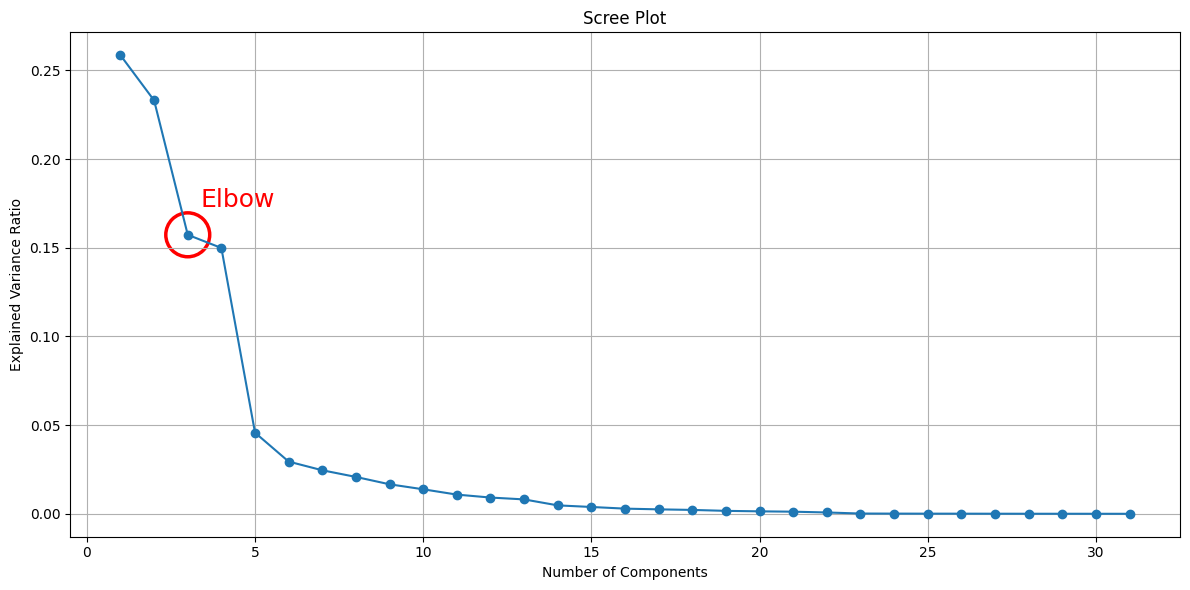

In [28]:
# Plot scree plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.scatter(3, explained_variance_ratio[2], color='none', edgecolor='red', s=1000, linewidth=2.5)
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.annotate('Elbow', xy=(10, explained_variance_ratio[8]), xytext=(-160, 200),
             textcoords='offset points', fontsize=18, color='red')
plt.tight_layout()
plt.show()

In [29]:
# Fit PCA with 3 components
pca_3 = PCA(n_components=3)
reviews_books_cleaned_pca_3 = pca_3.fit_transform(reviews_books_cleaned)

In [30]:
# Calculate the sum of explained variance ratios
total_variance_ratio = sum(pca_3.explained_variance_ratio_)

# Create DataFrame for reporting the percentage of variance retained
explained_variance = pd.DataFrame(pca_3.explained_variance_ratio_, columns=['Explained Variance Ratio'], index=['PC1', 'PC2', 'PC3'])
explained_variance.loc['Total'] = total_variance_ratio
explained_variance.T

,PC1,PC2,PC3,Total
Explained Variance Ratio,0.258576,0.233099,0.157335,0.64901


> In the data preprocessing phase, we tackle several key challenges to prepare our dataset for analysis. Initially, we address the skewness observed in the score distribution by applying a *Logarithmic Transformation*, ensuring a more symmetrical distribution and enhancing the performance of subsequent analyses. Given the substantial size of our dataset, we acknowledge the computational complexity associated with clustering and opt to mitigate this by reducing its dimensionality through *Undersampling*, particularly for the imbalanced categories. Furthermore, to facilitate effective modeling, we employ *One-hot Encoding* to represent categorical variables and *Standard Scaling* to normalize numerical features, ensuring uniformity and comparability across different scales. Recognizing the redundancy and lower correlation of the summary score with sentiment analysis compared to the text score, we make the decision to exclude the summary score from further analyses, streamlining our feature set for greater efficiency.

> Lastly, informed by the scree plot analysis, we determine the optimal number of principal components for *Dimensionality Reduction* through PCA. With the scree plot illustrating diminishing returns beyond three components, we proceed to fit a PCA model with three components. The cumulative explained variance ratio indicates that these components collectively capture 64.90% of the variance within the data, with the first component explaining 25.86%, the second component 23.31%, and the third component 15.73%. This reduction in dimensionality while retaining a significant portion of the variance enables more efficient and effective analysis of our dataset.

## Clustering Analysis

- ### Agglomerative Clustering

In [31]:
X = reviews_books_cleaned_pca_3

# Range of clusters to test
range_n_clusters = [2, 3, 4, 5, 6]
best_avg_silhouette_score = -1
optimal_n_clusters = -1


for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters and random generator seed for reproducibility
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    cluster_labels = clusterer.fit_predict(X)

    # Compute the average silhouette score for all samples
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Determine the optimal number of clusters based on the highest average silhouette score
    if silhouette_avg > best_avg_silhouette_score:
        best_avg_silhouette_score = silhouette_avg
        optimal_n_clusters = n_clusters

For n_clusters = 2 The average silhouette_score is : 0.7389563886207987
For n_clusters = 3 The average silhouette_score is : 0.7175661185816635
For n_clusters = 4 The average silhouette_score is : 0.7065222104673097
For n_clusters = 5 The average silhouette_score is : 0.7064212180712865
For n_clusters = 6 The average silhouette_score is : 0.5050158683574189


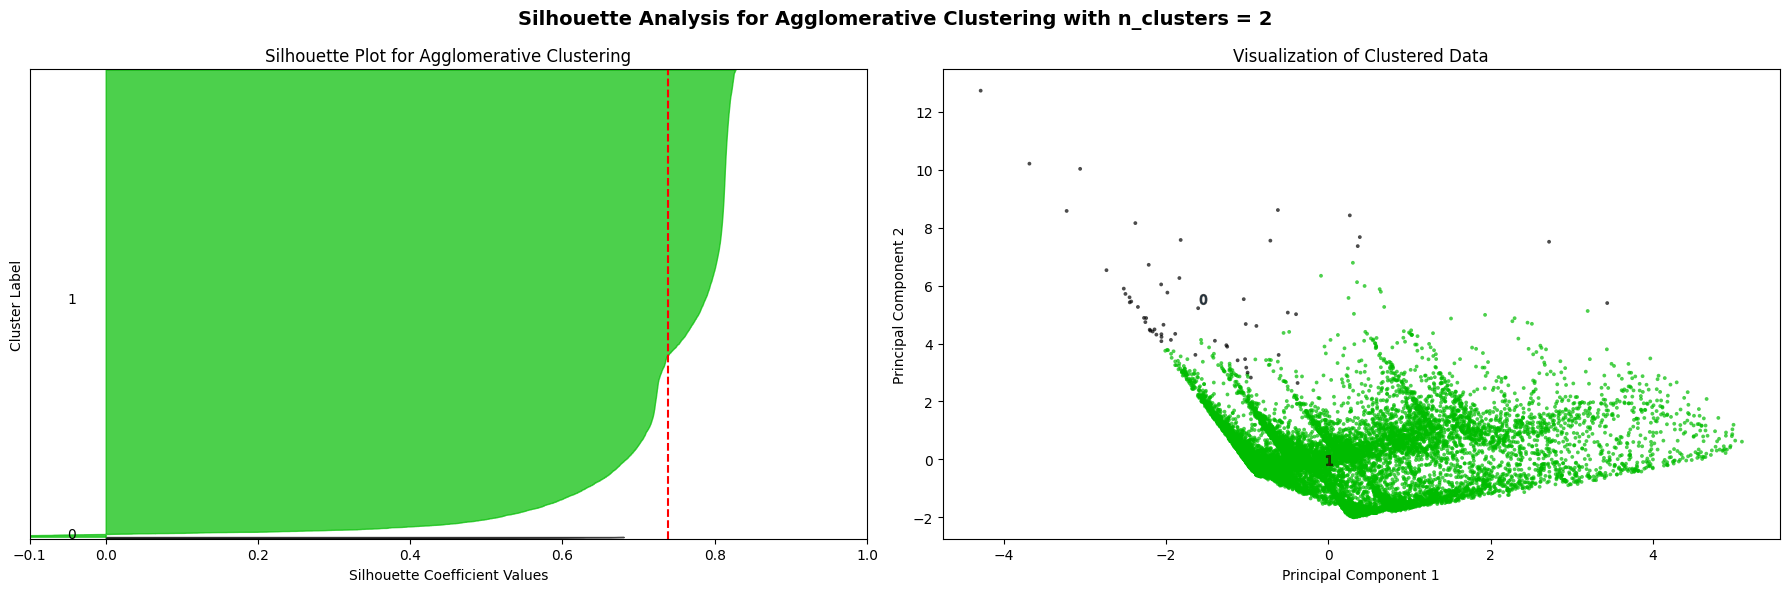

In [32]:
# Compute silhouette scores for different number of clusters
silhouette_scores = []
cluster_centers = []
for n_clusters in range(2, 11):
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    centers = np.array([X[cluster_labels == i].mean(axis=0) for i in range(n_clusters)])
    cluster_centers.append(centers)

# Find the optimal number of clusters
optimal_n_clusters = np.argmax(silhouette_scores) + 2
best_avg_silhouette_score = silhouette_scores[optimal_n_clusters - 2]

# Create a silhouette plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# 1st subplot: silhouette plot
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (optimal_n_clusters + 1) * 10])

clusterer = AgglomerativeClustering(n_clusters=optimal_n_clusters, linkage='average')
cluster_labels = clusterer.fit_predict(X)
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(optimal_n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / optimal_n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax1.axvline(x=best_avg_silhouette_score, color="red", linestyle="--")
ax1.set_yticks([])
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

ax1.set_title("Silhouette Plot for Agglomerative Clustering")
ax1.set_xlabel("Silhouette Coefficient Values")
ax1.set_ylabel("Cluster Label")

# 2nd subplot: scatter plot of clusters
colors = cm.nipy_spectral(cluster_labels.astype(float) / optimal_n_clusters)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

for i, centers in enumerate(cluster_centers[optimal_n_clusters - 2]):
    ax2.scatter(centers[0], centers[1], marker='$%d$' % i, alpha=0.7, s=50, edgecolor='k')

ax2.set_title("Visualization of Clustered Data")
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("Principal Component 2")

plt.suptitle(f"Silhouette Analysis for Agglomerative Clustering with n_clusters = {optimal_n_clusters}", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

> Based on the results of the *Silhouette Analysis*, we determine that the optimal number of clusters using the *Agglomerative Clustering* method is 2.

- ### K-means Clustering

In [33]:
X = reviews_books_cleaned_pca_3

# Range of clusters to test
range_n_clusters = [2, 3, 4, 5, 6]
best_avg_silhouette_score = -1
optimal_n_clusters = -1

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters and random generator seed for reproducibility
    clusterer = KMeans(n_clusters=n_clusters, n_init='auto', init='k-means++', random_state=618)
    cluster_labels = clusterer.fit_predict(X)

    # Compute the average silhouette score for all samples
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Determine the optimal number of clusters based on the highest average silhouette score
    if silhouette_avg > best_avg_silhouette_score:
        best_avg_silhouette_score = silhouette_avg
        optimal_n_clusters = n_clusters

d:\Studies\UMich\MAS Program\2024 Winter\SI 618\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Studies\UMich\MAS Program\2024 Winter\SI 618\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


For n_clusters = 2 The average silhouette_score is : 0.45391699050404083
For n_clusters = 3 The average silhouette_score is : 0.5102684935286276
For n_clusters = 4 The average silhouette_score is : 0.5355957294234123
For n_clusters = 5 The average silhouette_score is : 0.5100058989148677
For n_clusters = 6 The average silhouette_score is : 0.43056886506633263


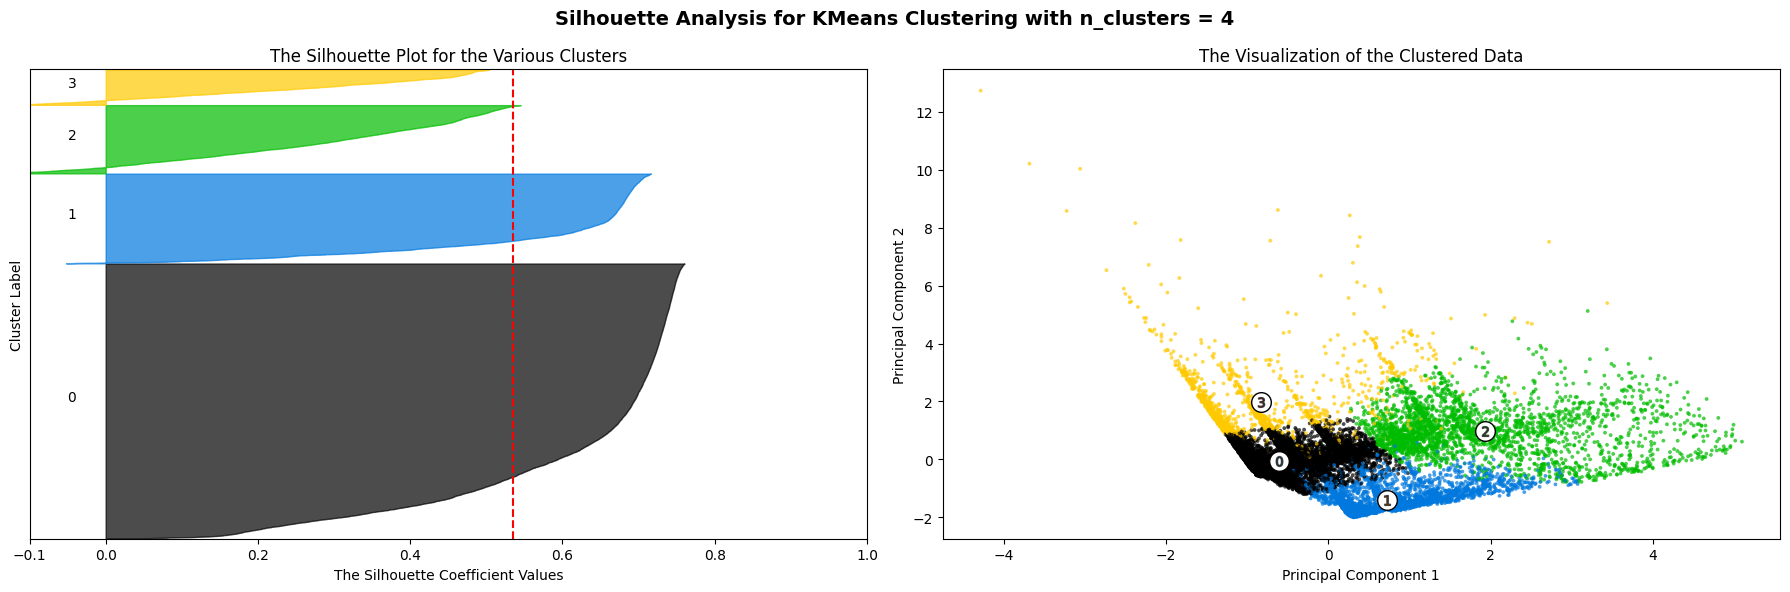

In [34]:
# Silhouette plot for the clustering solution using the optimal number of clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# The 1st subplot is the silhouette plot
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (optimal_n_clusters + 1) * 10])

# Initialize the clusterer with optimal_n_clusters and random generator seed for reproducibility
clusterer = KMeans(n_clusters=optimal_n_clusters, n_init='auto', init='k-means++', random_state=618)
cluster_labels = clusterer.fit_predict(X)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(optimal_n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / optimal_n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax1.set_title("The Silhouette Plot for the Various Clusters")
ax1.set_xlabel("The Silhouette Coefficient Values")
ax1.set_ylabel("Cluster Label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=best_avg_silhouette_score, color="red", linestyle="--")
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / optimal_n_clusters)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=0.7, s=50, edgecolor='k')

ax2.set_title("The Visualization of the Clustered Data")
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("Principal Component 2")

plt.suptitle(("Silhouette Analysis for KMeans Clustering with n_clusters = %d" % optimal_n_clusters), fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

> Based on the results of the *Silhouette Analysis*, we determine that the optimal number of clusters using the *K-means Clustering* method is 4.

- ### Agglomerative Clustering vs K-means Clustering

> After comparing the performance of the two clustering methods, we observe that although the silhouette score of *Agglomerative Clustering* is higher than that of *K-means*, the silhouette plot reveals a more distinct and well-defined cluster pattern in *K-means*. Therefore, we make the decision to cluster our customers into 4 clusters using the *K-means Clustering* method.

In [35]:
# Add the cluster labels to the original DataFrame
reviews_books_cleaned['Cluster'] = cluster_labels

# Count the number of each cluster
reviews_books_cleaned['Cluster'].value_counts()

Cluster
0    10265
1     3347
2     2549
3     1316
Name: count, dtype: int64

In [46]:
# Group the data by cluster membership and calculate the mean of different features
round(reviews_books_cleaned.groupby('Cluster').mean(), 3)

,review/helpfulness,text_count,sentiment_score_text,review/score_norm,categories_Business & Economics,categories_Computers,categories_Fiction,categories_History,categories_Juvenile Fiction,categories_Juvenile Nonfiction,...,authors_Zane Grey,publisher_Courier Corporation,publisher_Harper Collins,publisher_John Wiley & Sons,publisher_Macmillan,publisher_Other,publisher_Penguin,publisher_Routledge,publisher_Simon and Schuster,publisher_Vintage
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.527,-0.184,0.353,0.303,0.064,0.049,0.254,0.097,0.081,0.048,...,0.001,0.007,0.015,0.013,0.010,0.886,0.020,0.013,0.023,0.007
1,-1.814,-0.452,0.142,0.132,0.062,0.040,0.273,0.087,0.096,0.040,...,0.001,0.004,0.022,0.009,0.010,0.863,0.032,0.016,0.031,0.008
2,0.048,0.002,-1.711,-1.437,0.061,0.071,0.314,0.147,0.048,0.019,...,0.000,0.003,0.016,0.016,0.013,0.870,0.023,0.016,0.026,0.010
3,0.410,2.577,0.199,0.085,0.075,0.039,0.270,0.157,0.042,0.015,...,0.000,0.005,0.015,0.017,0.016,0.855,0.026,0.016,0.021,0.011


> The dataset has been clustered into four distinct groups labeled as 0, 1, 2, and 3. The distribution of data among these clusters varies, with *Cluster 0* being the largest group (10,265 reviews), followed by *Clusters 1* (3,347 reviews), *2* (2,549 reviews), and *3* (1,316 reviews). Interestingly, *Cluster 2* exhibits a significantly negative sentiment score, suggesting a predominance of negative sentiment in the reviews within this cluster. Moreover, *Clusters 0* and *1* have slightly higher normalized review scores compared to *Clusters 2* and *3*, indicating relatively more positive overall review scores. This clustering analysis offers valuable insights into the diverse segments within the dataset, which can guide the selection of pertinent variables for subsequent classification tasks.

## Model Selection

In [37]:
# Extracting the target variable
X = reviews_books_cleaned.drop(['Cluster'], axis=1)
y = reviews_books_cleaned['Cluster']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True, random_state=618)

In [38]:
# Classifiers with default configurations
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=618),
    "KNN" : KNeighborsClassifier(),
    "SVC" : SVC(random_state=618, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=618),
    "XGBoost" : XGBClassifier(random_state=618, use_label_encoder=False, eval_metric='logloss'),
    "AdaBoost" : AdaBoostClassifier(random_state=618),
}

In [39]:
# Hyperparameter grids for grid search
LR_grid = {'penalty': ['l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200],
           'max_depth': [4, 6, 8, 10, 12]}

boost_grid = {'n_estimators': [50, 100, 150, 200],
              'max_depth': [4, 8, 12],
              'learning_rate': [0.05, 0.1, 0.15, 0.5]}

adaboost_grid = {'n_estimators': [50, 100, 150, 200],
                 'learning_rate': [0.05, 0.1, 0.15, 0.5]}

# Dictionary containing all hyperparameter grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boost_grid,
    "AdaBoost" : adaboost_grid,
}

d:\Studies\UMich\MAS Program\2024 Winter\SI 618\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


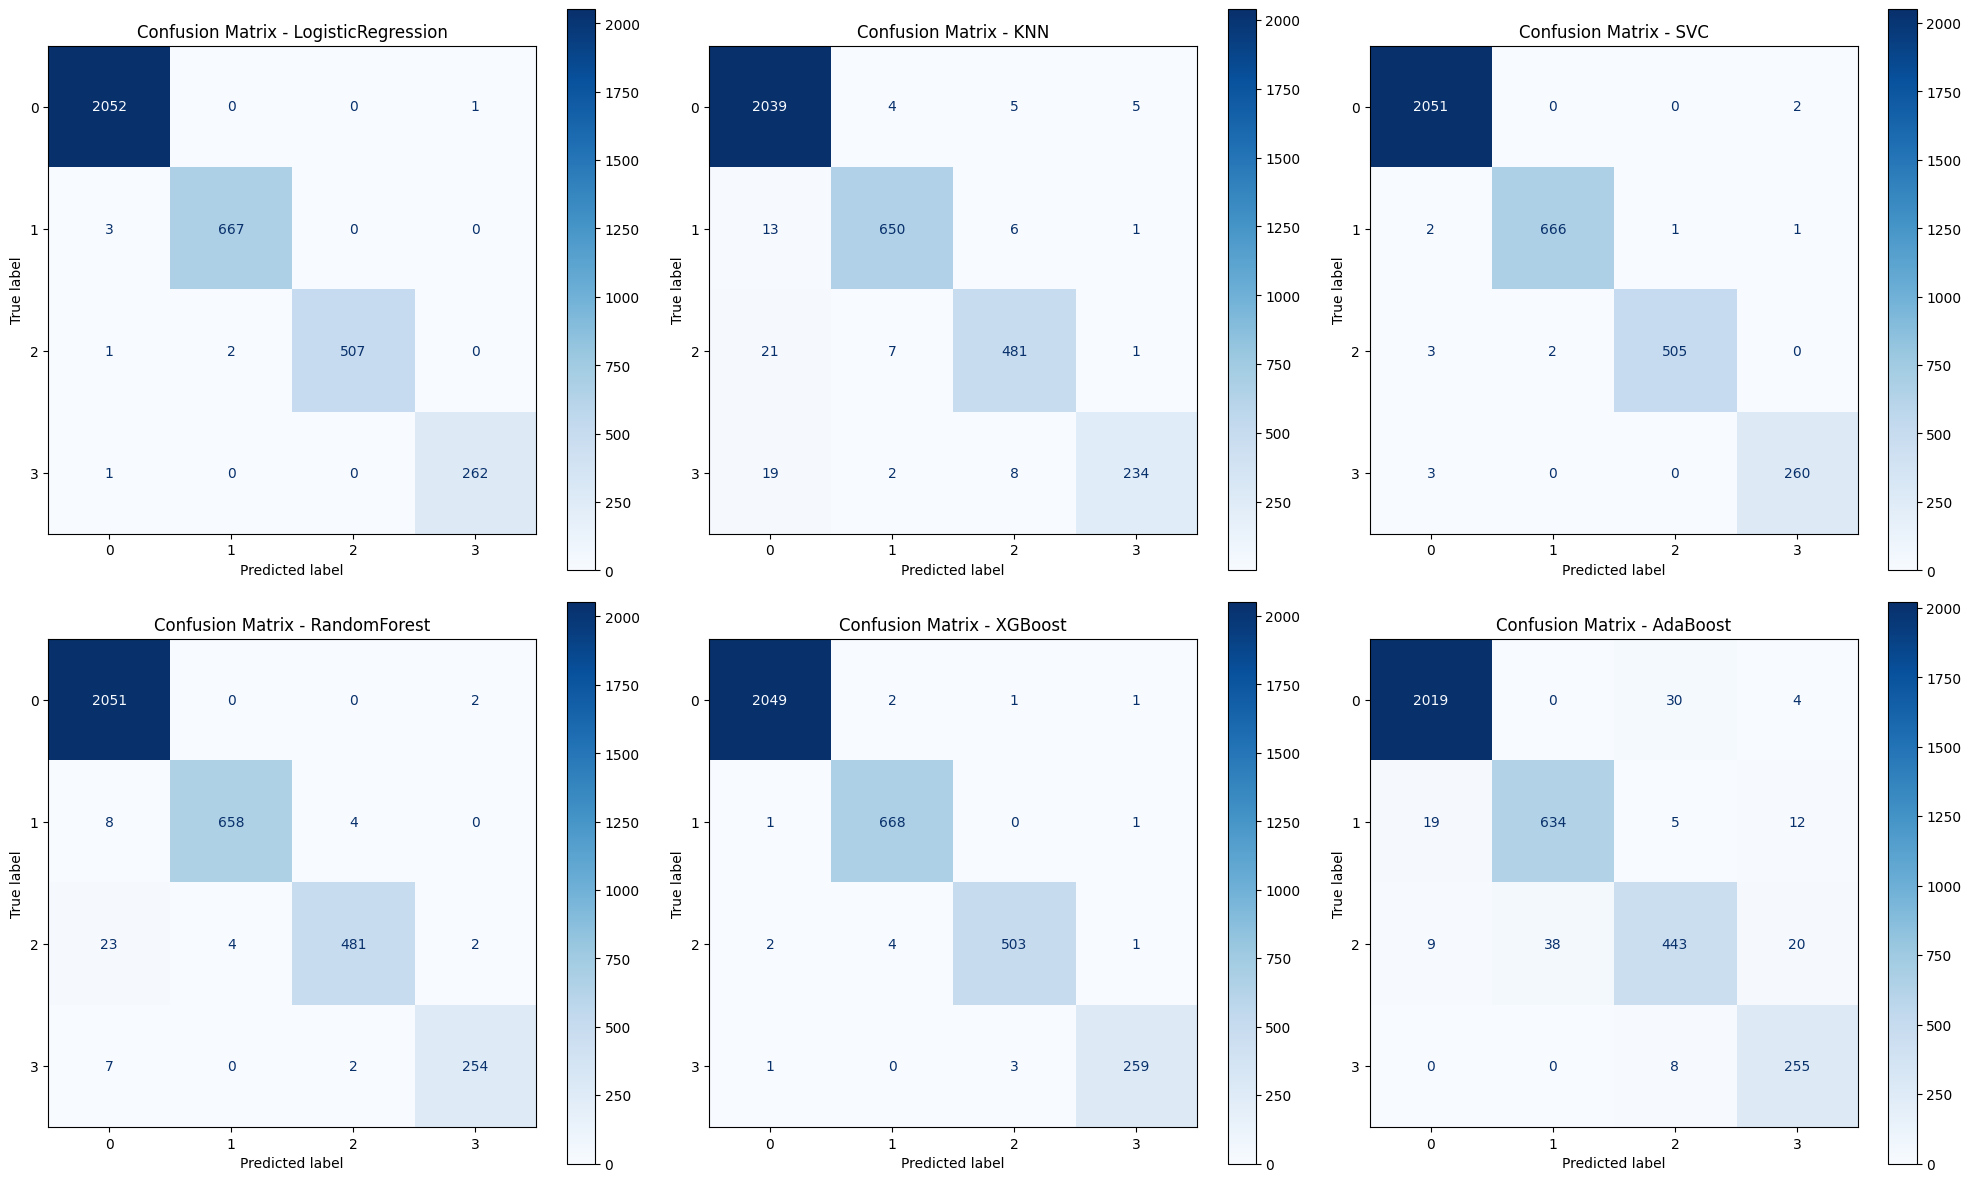

In [40]:
# Initialize index variable and create a copy of classifiers dictionary to store best parameters
i = 0
clf_best_params = classifiers.copy()

# Initialize a DataFrame to store test accuracy and training time for each classifier
test_scores = pd.DataFrame({'Classifier': classifiers.keys(),
                            'Test Accuracy': np.zeros(len(classifiers)),
                            'Training Time': np.zeros(len(classifiers))})

# Set the fold for cross-validation
folds = KFold(n_splits=10, shuffle=True, random_state=618)

# Create a subplot grid
fig, axs = plt.subplots(2, 3, figsize=(20, 12))

# Loop through each classifier in the classifiers dictionary
for key, classifier in classifiers.items():
    # Record start time for training
    start = time.time()

    # Initialize GridSearchCV for hyperparameter tuning
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=folds)

    # Train the classifier and score on test set
    clf.fit(X_train, y_train)
    test_scores.iloc[i, 1] = clf.score(X_test, y_test)

    # Save the best parameters found by GridSearchCV
    clf_best_params[key] = clf.best_params_

    # Record end time for training and calculate training time in minutes
    stop = time.time()
    test_scores.iloc[i, 2] = np.round((stop - start) / 60, 2)

    # Predict on test set
    y_pred = clf.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix in the appropriate subplot
    ax = axs[i // 3, i % 3]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(f'Confusion Matrix - {key}')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.grid(False)

    # Increment index variable
    i += 1

plt.tight_layout()
plt.show()

In [41]:
# Display the summary of individual model performance
test_scores

,Classifier,Test Accuracy,Training Time
0,LogisticRegression,0.997712,0.19
1,KNN,0.973684,0.07
2,SVC,0.995995,3.02
3,RandomForest,0.985126,0.52
4,XGBoost,0.995137,1.32
5,AdaBoost,0.958524,0.77


> The accuracy table demonstrates robust performance across all models, with the *AdaBoost* model achieving a lowest accuracy score of 0.9585 and the *Logistic Regression* model exhibiting the highest accuracy at 0.9977. Upon closer inspection of the confusion matrices, it becomes evident that the *Logistic Regression* model, alongside *SVC* and *XGBoost*, excels in accurately classifying cases into their respective classes. Given its superior performance and accuracy, the *Logistic Regression* model emerges as the preferred choice for classification in this analysis.

## Summary

> The analysis of Amazon book reviews encompassed several preprocessing steps, including data cleaning, feature engineering, and categorical variable encoding. Following these steps, the dataset underwent clustering analysis to uncover distinct segments within the reviews. By leveraging silhouette analysis and visual inspection, the optimal number of clusters was identified. This clustering process yielded valuable insights into different segments of the dataset, facilitating targeted marketing strategies and customer segmentation efforts. Subsequently, classification models were trained using *10-fold Cross-validation* and assessed to predict review categories based on various features. While all models demonstrated high accuracy, *Logistic Regression* stood out for its superior performance in accurately classifying review categories, as confirmed by the confusion matrices. In conclusion, this analysis offers valuable insights for comprehending Amazon book reviews, segmenting customers, and effectively categorizing review content to enhance customer satisfaction and refine business strategies.